In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Device: cuda
Loaded records: 54
Total windows: 12924
Epoch 001 | Missing-only MAE=36.385231
Epoch 002 | Missing-only MAE=3.133697
Epoch 003 | Missing-only MAE=3.113604
Epoch 004 | Missing-only MAE=2.647926
Epoch 005 | Missing-only MAE=1.967092
Epoch 006 | Missing-only MAE=1.151070
Epoch 007 | Missing-only MAE=0.924007
Epoch 008 | Missing-only MAE=0.738418
Epoch 009 | Missing-only MAE=0.661858
Epoch 010 | Missing-only MAE=0.590688
Epoch 011 | Missing-only MAE=0.533527
Epoch 012 | Missing-only MAE=0.530122
Epoch 013 | Missing-only MAE=0.491636
Epoch 014 | Missing-only MAE=0.486985
Epoch 015 | Missing-only MAE=0.475936
Epoch 016 | Missing-only MAE=0.456019
Epoch 017 | Missing-only MAE=0.441451
Epoch 018 | Missing-only MAE=0.442957
Epoch 019 | Missing-only MAE=0.412089
Epoch 020 | Missing-only MAE=0.434809

================ Random Missing Debug (LSTM) ================
K=5 random missing points
Deleted indices     : [16, 24, 32, 33, 43]
Deleted TRUE values : [89.52210235595703, 89.481597900

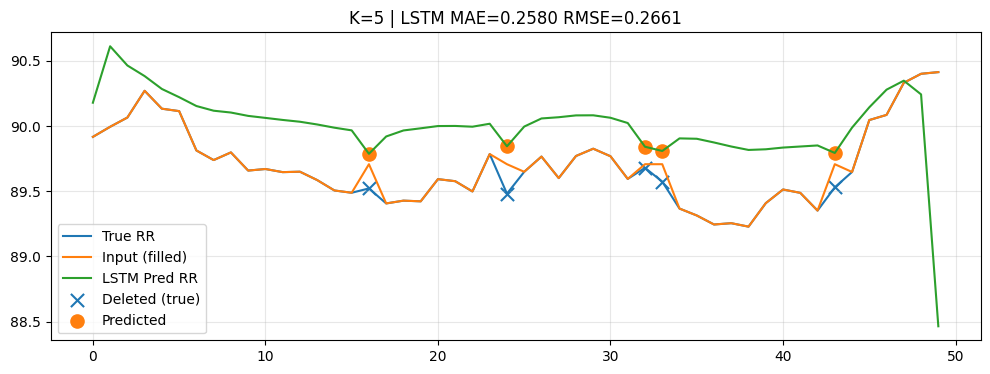

Saved: /kaggle/working/lstm_rr_imputer_random_missing.pt


In [6]:
# ============================================================
# LSTM-only RR Imputation (RANDOM missingness)
# - Randomly delete K points in each window
# - Train LSTM to predict missing values
# - Loss only on missing points
# - Debug print + plot
# ============================================================

import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# -------------------------
# CONFIG
# -------------------------
WINDOW_LEN   = 50
STRIDE       = 5
K_MISSING    = 5          # RANDOM missing points per window
BATCH_SIZE   = 128
EPOCHS       = 20
LR           = 2e-3
SEED         = 42
FILL_MODE    = "mean"     # input fill only: "mean" (recommended)

# -------------------------
# Reproducibility
# -------------------------
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============================================================
# 1) LOAD RR RECORDS
# ============================================================
# Replace this dummy rr_records with your real rr_records
rr_records = []
for _ in range(54):
    L = np.random.randint(600, 1800)
    base = 90 + np.cumsum(np.random.randn(L) * 0.15)
    rr_records.append(base.astype(np.float32))
print("Loaded records:", len(rr_records))

# ============================================================
# 2) WINDOWING DATASET
# ============================================================
class RRWindowDataset(Dataset):
    def __init__(self, rr_records, window_len=50, stride=5):
        self.samples = []
        for rec in rr_records:
            rec = np.asarray(rec, dtype=np.float32)
            if len(rec) < window_len:
                continue
            for s in range(0, len(rec) - window_len + 1, stride):
                self.samples.append(rec[s:s+window_len])

        if len(self.samples) == 0:
            raise ValueError("No windows created. Check window_len/stride or data.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return torch.tensor(self.samples[idx], dtype=torch.float32)

# ============================================================
# 3) RANDOM MASK + FILL
# ============================================================
def make_random_mask_and_fill(x, K=5, fill_mode="mean"):
    """
    x: (B,T) full RR
    returns:
      x_in: (B,T) with missing filled (input to LSTM)
      m:    (B,T) mask, 1=observed, 0=missing
      idx_missing_list: list of index tensors
    """
    B, T = x.shape
    m = torch.ones((B, T), device=x.device)
    idx_missing_list = []

    for b in range(B):
        idx = torch.randperm(T, device=x.device)[:K]
        m[b, idx] = 0.0
        idx_missing_list.append(idx)

    if fill_mode == "mean":
        obs_sum = (x * m).sum(dim=1, keepdim=True)
        obs_cnt = m.sum(dim=1, keepdim=True).clamp(min=1.0)
        fill = obs_sum / obs_cnt
        x_in = x * m + fill * (1.0 - m)
    else:
        raise ValueError("Only fill_mode='mean' is implemented here.")

    return x_in, m, idx_missing_list

# ============================================================
# 4) LSTM IMPUTER MODEL
# ============================================================
class LSTMImputer(nn.Module):
    """
    Input features per time-step:
      [x_filled, mask]
    Output:
      predicted RR value per time-step
    """
    def __init__(self, hidden=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=2,
            hidden_size=hidden,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=True
        )
        self.head = nn.Sequential(
            nn.Linear(hidden * 2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, x_filled, m):
        inp = torch.stack([x_filled, m], dim=-1)  # (B,T,2)
        h, _ = self.lstm(inp)
        out = self.head(h).squeeze(-1)            # (B,T)
        return out

# ============================================================
# 5) TRAIN
# ============================================================
def train_lstm_imputer(rr_records):
    ds = RRWindowDataset(rr_records, window_len=WINDOW_LEN, stride=STRIDE)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    print("Total windows:", len(ds))

    model = LSTMImputer(hidden=64, num_layers=2, dropout=0.1).to(device)
    opt = optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.L1Loss(reduction="none")  # we will mask it manually

    for ep in range(1, EPOCHS + 1):
        model.train()
        loss_sum = 0.0

        for x in dl:
            x = x.to(device)  # (B,T)

            x_in, m, _ = make_random_mask_and_fill(x, K=K_MISSING, fill_mode=FILL_MODE)

            pred = model(x_in, m)  # (B,T)

            # Loss only on missing
            miss = (1.0 - m)
            denom = miss.sum().clamp(min=1.0)
            l = (loss_fn(pred, x) * miss).sum() / denom

            opt.zero_grad(set_to_none=True)
            l.backward()
            opt.step()

            loss_sum += l.item()

        print(f"Epoch {ep:03d} | Missing-only MAE={loss_sum/len(dl):.6f}")

    return model

# ============================================================
# 6) INFERENCE + DEBUG
# ============================================================
@torch.no_grad()
def impute_one_window(model, rr_window, K=5, verbose=True):
    model.eval()

    x = torch.tensor(rr_window, dtype=torch.float32, device=device).unsqueeze(0)  # (1,T)
    x_in, m, idx_list = make_random_mask_and_fill(x, K=K, fill_mode=FILL_MODE)
    idx_missing = idx_list[0].detach().cpu().numpy()

    pred = model(x_in, m).squeeze(0).cpu().numpy()
    x_true = x.squeeze(0).cpu().numpy()

    true_missing = x_true[idx_missing]
    pred_missing = pred[idx_missing]
    abs_err = np.abs(pred_missing - true_missing)

    mae = float(np.mean(abs_err))
    rmse = float(np.sqrt(np.mean((pred_missing - true_missing) ** 2)))

    if verbose:
        idx_s = np.array(sorted(idx_missing), dtype=int)
        print("\n================ Random Missing Debug (LSTM) ================")
        print(f"K={K} random missing points")
        print("Deleted indices     :", idx_s.tolist())
        print("Deleted TRUE values :", np.round(x_true[idx_s], 4).tolist())
        print("Predicted values    :", np.round(pred[idx_s], 4).tolist())
        print("Abs error           :", np.round(abs_err[np.argsort(idx_missing)], 4).tolist())
        print(f"Missing-only MAE={mae:.6f} | RMSE={rmse:.6f}")
        print("=============================================================\n")

    return x_true, x_in.squeeze(0).cpu().numpy(), pred, idx_missing, mae, rmse

def plot_imputation(x_true, x_in, x_pred, idx_missing, title="LSTM Imputation (Random Missing)"):
    plt.figure(figsize=(12,4))
    plt.plot(x_true, label="True RR")
    plt.plot(x_in, label="Input (filled)")
    plt.plot(x_pred, label="LSTM Pred RR")
    plt.scatter(idx_missing, x_true[idx_missing], marker="x", s=90, label="Deleted (true)")
    plt.scatter(idx_missing, x_pred[idx_missing], marker="o", s=90, label="Predicted")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ============================================================
# 7) RUN
# ============================================================
model = train_lstm_imputer(rr_records)

test_seq = rr_records[0][:WINDOW_LEN]
x_true, x_in, x_pred, idx_missing, mae, rmse = impute_one_window(
    model, test_seq, K=K_MISSING, verbose=True
)

plot_imputation(
    x_true, x_in, x_pred, idx_missing,
    title=f"K={K_MISSING} | LSTM MAE={mae:.4f} RMSE={rmse:.4f}"
)

# Save
MODEL_PATH = "/kaggle/working/lstm_rr_imputer_random_missing.pt"
torch.save({
    "model_state": model.state_dict(),
    "window_len": WINDOW_LEN,
    "k_missing": K_MISSING
}, MODEL_PATH)
print("Saved:", MODEL_PATH)
